In [1]:
import os
import torch
from torch.utils.data import DataLoader
from dataset.data_preparation import download, split_dataset
from dataset.super_resolution_dataset import SuperResolutionDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
torch.manual_seed(777)
transform = transforms.Compose([
        transforms.ToTensor()
    ])
download("./data", "airplanes")
root_dir = 'data/airplanes'
dataset = SuperResolutionDataset(root_dir=root_dir, transform=transform)
dataset_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Dataset airplanes already exists.


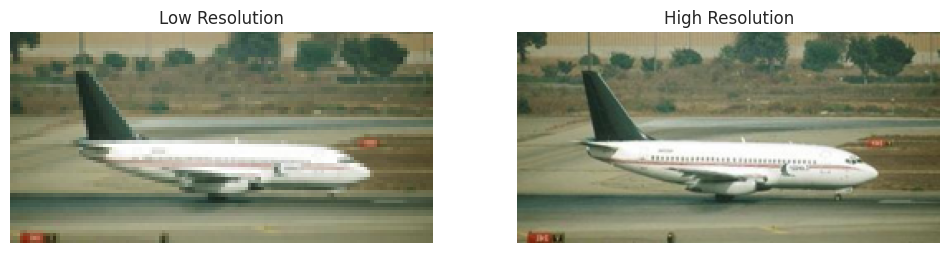

In [3]:
low_res, high_res = next(iter(dataset_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Tensors (channels, height, wight)
# matplot (height, wight, channels)
ax[0].imshow(low_res[0].permute(1, 2, 0))
ax[0].set_title("Low Resolution")
ax[0].axis('off')

ax[1].imshow(high_res[0].permute(1, 2, 0))
ax[1].set_title("High Resolution")
ax[1].axis('off')

plt.show()

In [4]:
sizes = {
    "train":0.5,
    "validation":0.3,
    "test":0.2
}
train, validation, test = split_dataset(dataset,sizes)

train_dataloader = DataLoader(train, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=True)

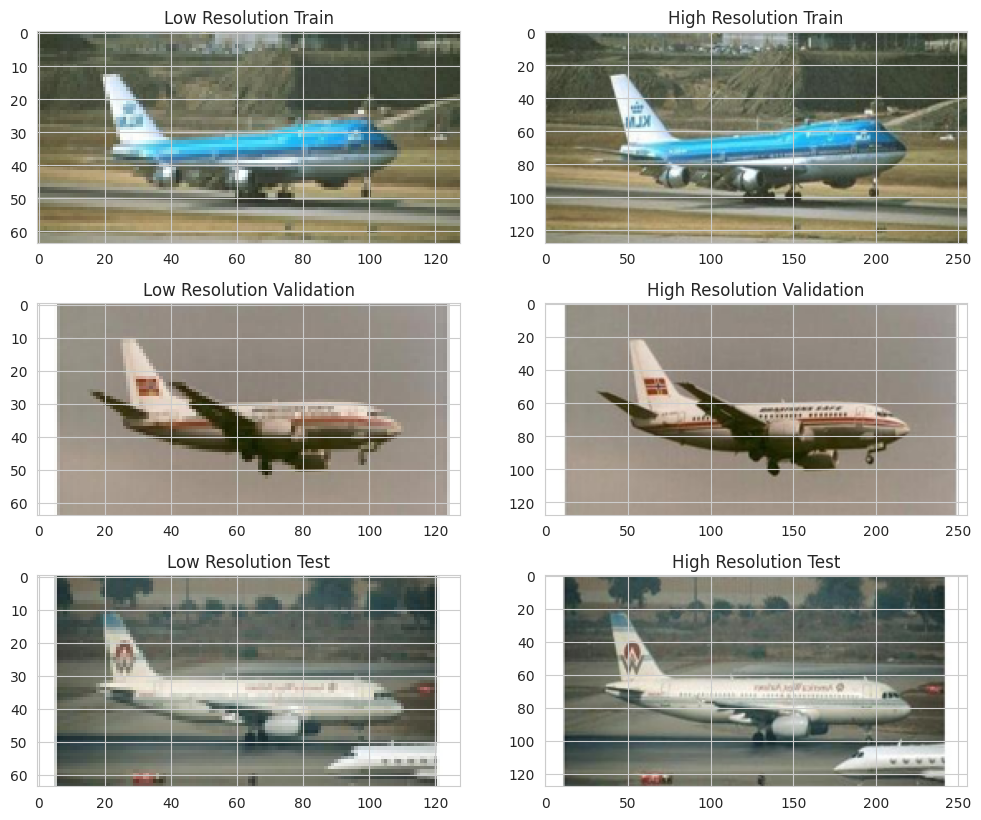

In [5]:
low_res_train, high_res_train = next(iter(train_dataloader))
low_res_validation, high_res_validation = next(iter(validation_dataloader))
low_res_test, high_res_test = next(iter(train_dataloader))
_ , ax = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle('Train-Validation-Test samples')

ax[0,0].set_title("Low Resolution Train")
ax[0,1].set_title("High Resolution Train")
ax[0,0].imshow(low_res_train[0].permute(1, 2, 0))
ax[0,1].imshow(high_res_train[0].permute(1, 2, 0))

ax[1,0].set_title("Low Resolution Validation")
ax[1,1].set_title("High Resolution Validation")
ax[1,0].imshow(low_res_validation[0].permute(1, 2, 0))
ax[1,1].imshow(high_res_validation[0].permute(1, 2, 0))

ax[2,0].set_title("Low Resolution Test")
ax[2,1].set_title("High Resolution Test")
ax[2,0].imshow(low_res_test[0].permute(1, 2, 0))
ax[2,1].imshow(high_res_test[0].permute(1, 2, 0))

plt.show()

In [6]:
from SRM.network import SuperResolution
num_channels = 64
num_res_block = 16
SRN = SuperResolution(num_channels,num_res_block)

In [7]:
from torch import nn
import torch.optim as optim

loss_fn = nn.L1Loss()
optimiser = optim.Adam(SRN.parameters(), lr=pow(10, -4))

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
SRN = SRN.to(device)
SRN.train()
losses = list()
epochs = 1000
for epoch in range(epochs):
    epoch_loss = 0
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)

        optimiser.zero_grad()

        output = SRN(x)

        loss = loss_fn(output, y)

        loss.backward()

        optimiser.step()

        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1}/{epochs}, L1 Loss: {avg_loss:.6f}',end="\r")
    losses.append(avg_loss)

KeyboardInterrupt: 

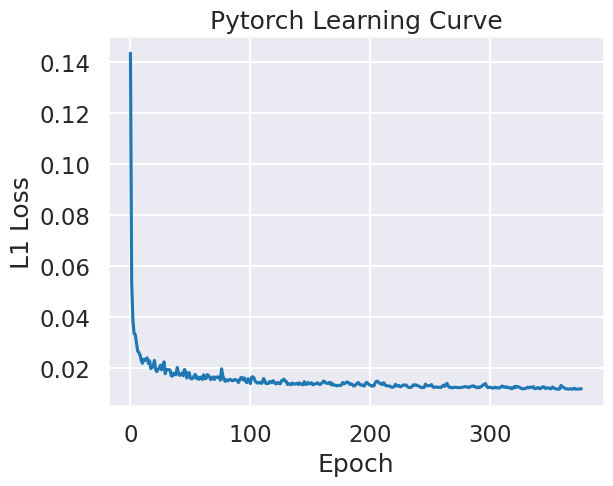

In [10]:
import seaborn as sns
import numpy as np

sns.set_style("darkgrid")
sns.set_context("talk")
sns.lineplot(x=np.arange(len(losses)), y=losses)
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Pytorch Learning Curve')
plt.show()

In [11]:
os.makedirs("checkpoint", exist_ok=True)    
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
model_filename = \
    f"checkpoint/SR_c_{num_channels}_rb_{num_res_block}_e{epochs}_{timestamp}.pth"
torch.save(SRN.state_dict(), model_filename)
print(f'Model saved as {model_filename}')

Model saved as checkpoint/SR_c_64_rb_16_e1000_20240804_1321.pth


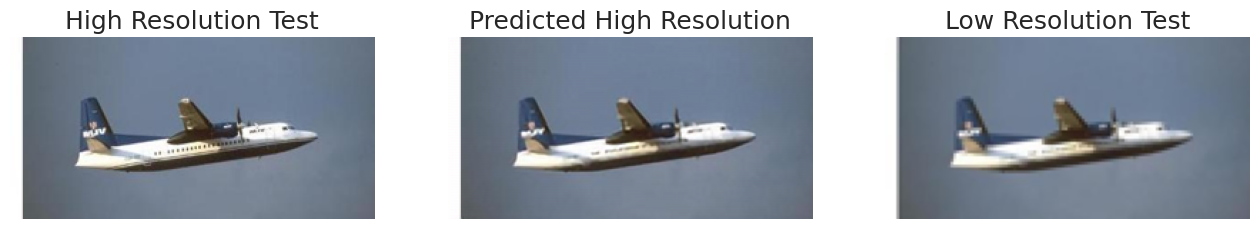

In [12]:
test_SRN = SuperResolution(num_channels,num_res_block)
test_SRN = test_SRN.to(device)

checkpoint_path = model_filename
test_SRN.load_state_dict(torch.load(checkpoint_path))
test_SRN.eval()

low_res_test, high_res_test = next(iter(test_dataloader))

low_res_test = low_res_test.to(device)

with torch.no_grad():
    predicted_high_res = SRN(low_res_test)
    
predicted_image = predicted_high_res[0].permute(1, 2, 0).cpu().numpy()
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()

_, ax = plt.subplots(1, 3, figsize=(16, 12)) 
fig.suptitle('High Resolution and Predicted High Resolution Samples')

ax[0].imshow(high_res_test[0].permute(1, 2, 0).cpu())
ax[0].set_title("High Resolution Test")
ax[0].axis('off') 

ax[1].imshow(predicted_image)
ax[1].set_title("Predicted High Resolution")
ax[1].axis('off')

ax[2].imshow(low_res_test[0].permute(1, 2, 0).cpu())
ax[2].set_title("Low Resolution Test")
ax[2].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/comparison.jpg")
plt.show()